In [1]:
import numpy as np
from Bio.Seq import Seq 
from Bio import SeqIO
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [6]:
def get_seqrange_from_caps(sequence):  
    # given a sequence with lower and upper case letters
    # return a list of STARTs and STOPs of upper case letters
    # lists should be same length
    
    current_state = 'lower'
    
    starts = []
    stops = []
    
    for i, letter in enumerate(sequence):
        
        if letter.isupper():
            this_letter = 'upper'
        else:
            this_letter = 'lower'
        
        if this_letter != current_state:
            
            if this_letter == 'upper':
                starts.append(i)
            else:
                stops.append(i)
                
            current_state = this_letter
    
    if current_state == 'upper':
        stops.append(len(sequence))
    return (starts, stops)

def find_ns(sequence):
    starts = []
    stops = []
    current_state = 'base'
    for i, s in enumerate(sequence):
        if s.lower() == 'n':
            base_state = 'n'
        else:
            base_state = 'base'
        
        if base_state != current_state:
            
            if base_state == 'n':
                starts.append(i)
                current_state = 'n'
            else:
                stops.append(i)
                current_state = 'base'
                
    if current_state == 'n':
        stops.append(len(sequence))
        
    return (starts, stops)

def print_exons(sequence, starts, stops):
    for i, s in enumerate(starts):
        print(sequence[s:stops[i]])

def get_feature_styles():
    feature_list = ['seq','gap','exon','primer','gRNA','amplicon']
    level_list =   [0,    0,    0.15,   0.05, 0.105 , 0.1      ] # distance with respect to sequence position
    
    # see WAY at bottom for named colors
    color_list = ['black','lightgray','tab:red','tab:blue','tab:green','tab:purple']
    
    # gRNA and primer = arrow; everything else = rectangle
    shape_list = ['rectangle','rectangle','rectangle','arrow','arrow','rectangle']

    feature_levels = dict(zip(feature_list,level_list))
    feature_colors = dict(zip(feature_list,color_list))
    feature_shapes = dict(zip(feature_list,shape_list))
    
    return feature_levels, feature_colors, feature_shapes
        
def plot_sequences(seq, exon_starts=[], exon_stops=[], features={}):
    feature_levels, feature_colors, feature_shapes = get_feature_styles()
    
    f,a = plt.subplots(figsize = (15,3))
    
    # sequence heights
    seq_height = 0.02
    seq_ylevel = 1
    
    # plot the sequence as a rectangle
    rect = Rectangle((0,seq_ylevel), len(seq), seq_height, fc = feature_colors['seq'])
    a.add_patch(rect)
    
    # plot n's as rectangles on top of the sequence
    startn, stopn = find_ns(seq)
    if len(startn) > 0:
        for i,pos in enumerate(startn):
            rect = Rectangle((pos, seq_ylevel), stopn[i]-pos, seq_height, fc = feature_colors['gap'] )
            a.add_patch(rect)
    
    # plot exons
    # exon size and connector parameters
    exon_color = feature_colors['exon']
    exon_ylevel = seq_ylevel + feature_levels['exon']    
    exon_height = 0.05   
    exon_connector_bottom = exon_ylevel + exon_height
    exon_connector_height = 0.015
    exon_connector_top = exon_connector_bottom + exon_connector_height
    exon_connector_linewidth = 1
    
    if len(exon_starts) > 0:
        for i, exon_start in enumerate(exon_starts):
            rect = Rectangle((exon_start, exon_ylevel), exon_stops[i]-exon_start, exon_height, fc = exon_color )
            a.add_patch(rect)

        # plot exon connectors
        for i, exon_stop in enumerate(exon_stops[:-1]):
            mid_point = (exon_starts[i+1] + exon_stop) / 2
            plt.plot([exon_stop, mid_point], [exon_connector_bottom, exon_connector_top], 
                     '-k', linewidth = exon_connector_linewidth)
            plt.plot([mid_point, exon_starts[i+1]], [exon_connector_top, exon_connector_bottom],
                     '-k', linewidth = exon_connector_linewidth)
    
    # plot other features
    if len(features) > 0:
        
        text_buffer = int(np.round(len(seq)/500)) + 2
        
        for feature in features.keys():

            start_feature = features[feature]['start']
            end_feature = features[feature]['end']
            
            feature_length = end_feature - start_feature
            feature_color = feature_colors[features[feature]['style']]
            
            
            if 'arrow' in feature_shapes[features[feature]['style']]:
                if features[feature]['strand'] == 'plus':
                    feature_ylevel = seq_ylevel + feature_levels[features[feature]['style']]
                    arrow_shape = 'right'
                    hzero = False
                else:
                    feature_ylevel = seq_ylevel - feature_levels[features[feature]['style']]
                    arrow_shape = 'left'
                    hzero = True
                
                plt.arrow(start_feature, feature_ylevel, feature_length, 0, head_starts_at_zero = hzero,
                          shape = arrow_shape, head_width = 0.02, head_length = 0.2 * feature_length,
                          color = feature_color, linewidth = 2)
                
            elif 'rectangle' in feature_shapes[features[feature]['style']]:
                feature_ylevel = seq_ylevel + feature_levels[features[feature]['style']]
                rect = Rectangle((start_feature, feature_ylevel), feature_length, exon_height, fc = feature_color )
                a.add_patch(rect)
                
            plt.text(start_feature + feature_length + text_buffer, feature_ylevel, feature, fontsize=16)
                
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['left'].set_visible(False)
    plt.xticks(fontsize = 16)
    plt.ylim([0.93, 1.55 ])
    plt.yticks([])
    plt.xlim([-5, len(seq) + 5])
    plt.xlabel('bases', fontsize = 16)
    plt.savefig('nav1a_exons.png', dpi=300)
    plt.show()
    
    
def find_subsequence(small_seq, big_seq):
    
    small_seq = small_seq.upper()
    big_seq = big_seq.upper()
    
    bigger = Seq(big_seq)
    smaller = Seq(small_seq)
    small_seq_start = bigger.find(small_seq)
    if small_seq_start > 0:
        return 'plus', small_seq_start, small_seq_start + len(small_seq)
    
    rc_smaller = smaller.reverse_complement()
    small_seq_start = bigger.find(rc_smaller)
    
    if small_seq_start > 0:
        return 'minus', small_seq_start, small_seq_start + len(small_seq)
    else:
        return 'none', -1, -1
    
def make_feature(features, feature_name, feature_seq, feature_style):
    feature_strand, feature_start, feature_end = find_subsequence(feature_seq,seq_string)
    features[feature_name] = {}
    features[feature_name]['style'] = feature_style
    features[feature_name]['strand'] = feature_strand
    features[feature_name]['start'] = feature_start
    features[feature_name]['end'] = feature_end
    return features

In [3]:
record = SeqIO.read("nav1a/nav1a_gDNA.fa", "fasta")
print("%s %i" % (record.id, len(record)))
seq_string = str(record.seq)

danRer11_ensGene_ENSDART00000183147.1 90072


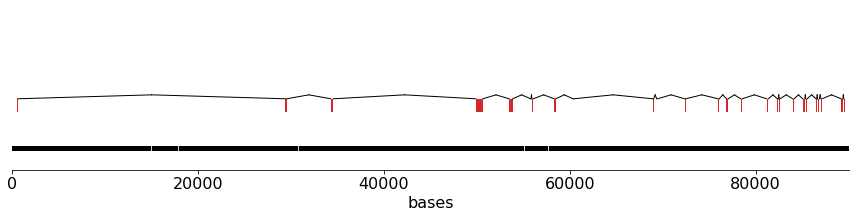

In [7]:
seq_to_plot = seq_string
exon_starts, exon_stops = get_seqrange_from_caps(seq_to_plot)
plot_sequences(seq_to_plot, exon_starts, exon_stops)

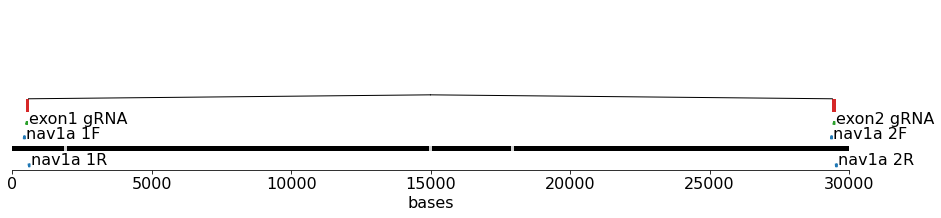

In [11]:
features = {}
seq_to_plot = seq_string[0:30000]
exon_starts, exon_stops = get_seqrange_from_caps(seq_to_plot)

feature_name = 'exon1 gRNA'
feature_seq = 'ATGAGCGGGCGGGTTCTCAACGG'
feature_style = 'gRNA'
features = make_feature(features, feature_name, feature_seq, feature_style)

feature_name = 'nav1a 1F'
feature_seq = 'CCGCTTCTCATTCAAACCTC'
feature_style = 'primer'
features = make_feature(features, feature_name, feature_seq, feature_style)

feature_name = 'nav1a 1R'
feature_seq = 'AGTCCAGCACTGGTTTGCTT'
feature_style = 'primer'
features = make_feature(features, feature_name, feature_seq, feature_style)

feature_name = 'exon2 gRNA'
feature_seq = 'ATCGGACAACCTCAGCTCCGAGG'
feature_style = 'gRNA'
features = make_feature(features, feature_name, feature_seq, feature_style)

feature_name = 'nav1a 2F'
feature_seq = 'AAACACCCTGCCGTGCAT'
feature_style = 'primer'
features = make_feature(features, feature_name, feature_seq, feature_style)

feature_name = 'nav1a 2R'
feature_seq = 'TTACCACAATGGCGGAGTTT'
feature_style = 'primer'
features = make_feature(features, feature_name, feature_seq, feature_style)

plot_sequences(seq_to_plot, exon_starts, exon_stops, features)

In [ ]:
# find a subsequence in a larger sequence, and return strand and start and end
big = 'AGAGGTAGGATGAC'
small = 'CATCC'
print(find_subsequence(small,big))

In [ ]:
# get starts and stops of exons (upper case) within gDNA (lower case)
seq = 'AaaAAAAAaannnnnnnnnnnnaAAAaaAa'
exon_starts, exon_stops = get_seqrange_from_caps(seq)
# print(exon_starts)
# print(exon_stops)
plot_sequences(seq, exon_starts, exon_stops)

In [ ]:
# use SeqIO to get sequences or a sequence
# 
for seq_record in SeqIO.parse("nav1a/nav1a_gDNA.fa", "fasta"):
    print(seq_record.id)
    print(repr(seq_record.seq))
    print(len(seq_record))
print()

record = SeqIO.read("nav1a/nav1a_gDNA.fa", "fasta")
print("%s %i" % (record.id, len(record)))
seq_string = str(record.seq)

In [ ]:
feature_levels, feature_colors, feature_shapes = get_feature_styles()
print(feature_levels)

In [ ]:
features = {}
feature_name = 'exon1_gRNA'
feature_seq = 'ATGAGCGGGCGGGTTCTCAACGG'
feature_style = 'gRNA'

def make_feature(features, feature_name, feature_seq, feature_style):
    feature_strand, feature_start, feature_end = find_subsequence(feature_seq,seq_string)
    features[feature_name] = {}
    features[feature_name]['style'] = feature_style
    features[feature_name]['strand'] = feature_strand
    features[feature_name]['start'] = feature_start
    features[feature_name]['end'] = feature_end
    return features

features = make_feature(features, feature_name, feature_seq, feature_style)
print(features)
plot_sequences(seq_string, exon_starts, exon_stops, features)

# simulating gel electrophoresis

In [ ]:
def virtual_pcr(seq, Fprimer, Rprimer):
    Fstrand, Fstart, Fend = find_subsequence(Fprimer, seq)
    Rstrand, Rstart, Rend = find_subsequence(Rprimer, seq)
    
    if Fstrand == 'plus' and Rstrand == 'minus':
        amplicon = seq[Fstart:Rend]
    elif Rstrand == 'plus' and Fstrand == 'minus':
        amplicon = seq[Rstart:Fend]
    else:
        amplicon = ''
    return amplicon

def gel_distance(fragment_size, gel_percentage):
    gel_percentage = 0.1 * gel_percentage**2
    return -(1 / fragment_size) ** gel_percentage

def plot_gel(data_matrix, gel_percentage=1, fig_size=(3,4)): # data_matrix is an array of arrays of fragment sizes
    lane_width = 0.8
    max_migration = 0
    min_migration = 100
    plt.figure(figsize = fig_size)
    for i,lane in enumerate(data_matrix):
        if len(lane) > 0:
            migration_distances = np.array([gel_distance(fragment, gel_percentage) for fragment in lane])
            max_migration_for_this_group = np.max(np.abs(migration_distances))
            min_migration_for_this_group = np.min(np.abs(migration_distances))
            if max_migration_for_this_group > max_migration:
                max_migration = max_migration_for_this_group
            if min_migration_for_this_group < min_migration:
                min_migration = min_migration_for_this_group
            for distance in migration_distances:
                plt.plot([i, i+lane_width],[distance, distance], '-k', linewidth = 2)
        else: # plot empty lane if nothing there
            plt.plot([i, i+lane_width],[distance, distance], '-w', linewidth = 2)
    plt.ylim([-1.05*max_migration, -0.95*min_migration])
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
def run_gel_test(gel_percentage=1):
    neb_100b_ladder = np.array([100, 200, 300, 400, 500, 517, 600, 700, 800, 900, 1000, 1050, 1200, 1517])
    neb_1kb_ladder = np.array([500, 1000, 1500, 2000, 3000, 3030, 4000, 5000, 6000, 8000, 10000])
    lane_1 = np.array([900])
    lane_2 = np.array([3000, 3010, 700])
    data_matrix = [neb_100b_ladder, lane_1, lane_2, neb_1kb_ladder]
    plot_gel(data_matrix,gel_percentage)

In [ ]:
record = SeqIO.read("nav1a/nav1a_gDNA.fa", "fasta")
print("%s %i" % (record.id, len(record)))
seq_string = str(record.seq)
feature_name = 'nav1a_2F'
F1 = 'CCGCTTCTCATTCAAACCTC'
R1 = 'AGTCCAGCACTGGTTTGCTT'
F2 = 'AAACACCCTGCCGTGCAT'
R2 = 'TTACCACAATGGCGGAGTTT'
F1R1_amplicon_length = len(virtual_pcr(seq_string, F1, R1))
F2R2_amplicon_length = len(virtual_pcr(seq_string, F2, R2))
print(F1R1_amplicon_length)
print(F2R2_amplicon_length)
F1R2_amplicon_length = 113

In [ ]:
neb_100b_ladder = np.array([100, 200, 300, 400, 500, 517, 600, 700, 800, 900, 1000, 1020, 1200, 1517])
F1R1_amplicon = [F1R1_amplicon_length, F1R1_amplicon_length+6, F1R1_amplicon_length-6]
F2R2_amplicon = [F2R2_amplicon_length, F2R2_amplicon_length+6, F2R2_amplicon_length-6]
F1R2_amplicon = [182]
data_matrix = [neb_100b_ladder, F1R1_amplicon, F2R2_amplicon, F1R2_amplicon]
plot_gel(data_matrix,1)

In [ ]:
'''
Actin: expect 706 b
TH1: expect 693 b
TH2: expect 897 b
TH3: expect 590 b
TH4: expect 694 b
'''
neb_1kb_ladder = np.array([500, 1000, 1500, 2000, 3000, 3050, 3100, 4000, 5000, 6000, 8000, 10000])
neb_100b_ladder = np.array([100, 200, 300, 400, 500, 517, 600, 700, 800, 900, 1000, 1050, 1200, 1517])
# actin = [706]
# TH1 = [693]
# TH2 = [897]
# TH3 = [590]
# TH4 = [694]
# data_matrix = [neb_1kb_ladder, actin, TH1, TH2, TH3, TH4]

# TH2 = [2588, 2688, 897]
# TH3 = [2588, 2688, 590]
# TH4 = [2588, 2688, 694]

nav1a = [2588, 2638, 789]
nav1b = [2588, 2638, 727]

data_matrix = [neb_1kb_ladder, nav1a, nav1b]
plot_gel(data_matrix,1, (3,6))



# matplotlib colors

In [ ]:
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


def plot_colortable(colors, title, sort_colors=True, emptycols=0):

    cell_width = 212
    cell_height = 22
    swatch_width = 48
    margin = 12
    topmargin = 40

    # Sort colors by hue, saturation, value and name.
    if sort_colors is True:
        by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))),
                         name)
                        for name, color in colors.items())
        names = [name for hsv, name in by_hsv]
    else:
        names = list(colors)

    n = len(names)
    ncols = 4 - emptycols
    nrows = n // ncols + int(n % ncols > 0)

    width = cell_width * 4 + 2 * margin
    height = cell_height * nrows + margin + topmargin
    dpi = 72

    fig, ax = plt.subplots(figsize=(width / dpi, height / dpi), dpi=dpi)
    fig.subplots_adjust(margin/width, margin/height,
                        (width-margin)/width, (height-topmargin)/height)
    ax.set_xlim(0, cell_width * 4)
    ax.set_ylim(cell_height * (nrows-0.5), -cell_height/2.)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.set_axis_off()
    ax.set_title(title, fontsize=24, loc="left", pad=10)

    for i, name in enumerate(names):
        row = i % nrows
        col = i // nrows
        y = row * cell_height

        swatch_start_x = cell_width * col
        text_pos_x = cell_width * col + swatch_width + 7

        ax.text(text_pos_x, y, name, fontsize=14,
                horizontalalignment='left',
                verticalalignment='center')

        ax.add_patch(
            Rectangle(xy=(swatch_start_x, y-9), width=swatch_width,
                      height=18, facecolor=colors[name], edgecolor='0.7')
        )

    return fig

plot_colortable(mcolors.BASE_COLORS, "Base Colors",
                sort_colors=False, emptycols=1)
plot_colortable(mcolors.TABLEAU_COLORS, "Tableau Palette",
                sort_colors=False, emptycols=2)

plot_colortable(mcolors.CSS4_COLORS, "CSS Colors")

# Optionally plot the XKCD colors (Caution: will produce large figure)
# xkcd_fig = plot_colortable(mcolors.XKCD_COLORS, "XKCD Colors")
# xkcd_fig.savefig("XKCD_Colors.png")

plt.show()